In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
titanic_data = pd.read_csv("./titanic_data.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Data  Preprocessing

In [3]:
print("Missing values")
titanic_data.isnull().any(axis=1).sum()

Missing values


708

That's a lot of missing values, let's see how they are distributed

In [4]:
titanic_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can just drop the cabin column as it isn't important, we will also drop the Name, PassengerId and Ticket columns

In [5]:
treated_data = titanic_data.drop(['Cabin','Name', 'PassengerId', 'Ticket'], axis=1)

Also, the embarked column NaN indicates that a passenger did not embark, we can just drop those passenger, along with the ones with NaN ages

In [6]:
treated_data = treated_data.dropna()
treated_data.isnull().any(axis=1).sum()

0

We no longer have any null value, lets check for outliers in the age column

0.42 80.0


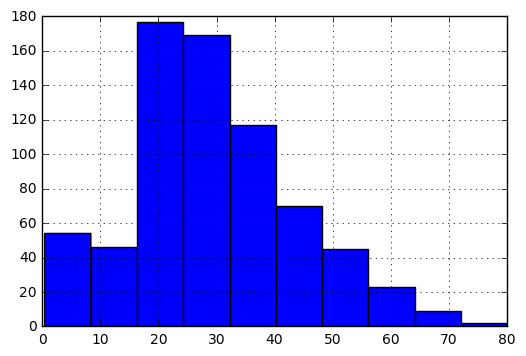

In [7]:
treated_data['Age'].hist()
print(treated_data['Age'].min(), treated_data['Age'].max())

Alright, that seems to be ok, lastly, we will drop the ticket column, as it does not seems relevant and will convert male/female to 0/1 and the embarking ports to 0/1/2

In [8]:
treated_data = treated_data.replace(['male', 'female'],[0,1]).replace(['S','C','Q'], [0,1,2])
treated_data=treated_data.astype(np.float32)

In [9]:
treated_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3.0,0.0,22.0,1.0,0.0,7.250000,0.0
1,1.0,1.0,1.0,38.0,1.0,0.0,71.283302,1.0
2,1.0,3.0,1.0,26.0,0.0,0.0,7.925000,0.0
3,1.0,1.0,1.0,35.0,1.0,0.0,53.099998,0.0
4,0.0,3.0,0.0,35.0,0.0,0.0,8.050000,0.0


We are now ready to do the machine learning bit

# Machine Learning

First Off, let's take our splits, we will use a 70/30 split scheme to train/test, let's also prepare the Y values (survive/no-survive), we will convert the survived column into a one-hot encoding, [0, 1] begin no-survive and [1, 0] being survive

In [10]:
train = treated_data.sample(frac=0.7)
test = treated_data.drop(train.index)
train_Y = train['Survived'].apply(lambda x: [0.,1.] if x == 0 else [1.,0.]).as_matrix()
train.drop('Survived', axis=1, inplace=True)
test_Y = test['Survived'].apply(lambda x: [0.,1.] if x == 0 else [1.,0.]).as_matrix()
test.drop('Survived', axis=1, inplace=True)
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
393,1.0,1.0,23.0,1.0,0.0,113.275002,1.0
314,2.0,0.0,43.0,1.0,1.0,26.250000,0.0
321,3.0,0.0,27.0,0.0,0.0,7.895800,0.0
281,3.0,0.0,28.0,0.0,0.0,7.854200,0.0
484,1.0,0.0,25.0,1.0,0.0,91.079201,1.0


We will now create our TensorFlow model for training

In [11]:
# Network architeture
# Hidden layers size, you can mess with these sizes to
# see if there's an gain in accuracy
n_hidden_1 = 15
n_hidden_2 = 15
# These are the inputs and outputs size
# You shouldn't have to touch these
n_inputs = 7
n_classes = 2

In [12]:
# Creating the input and output placeholders
x = tf.placeholder(tf.float32, [None, n_inputs],  name="input")
y = tf.placeholder(tf.float32, [None, n_classes], name="survival")

In [13]:
# We want probabilities that the passenger belongs to a given class (survive/no-survive)
# so we will use the softmax activation function
def makeModel(x, w, biases):
    # Hidden layer with Softmax activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'], name='layer_1')
    layer_1 = tf.nn.softmax(layer_1)
    # Hidden layer with Softmax activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'], name='layer_2')
    layer_2 = tf.nn.softmax(layer_2)
    # Output layer with softmax activation
    out_layer = tf.nn.softmax(tf.add(tf.matmul(layer_2, weights['out']), biases['out'], name='out_layer'))
    return out_layer

In [14]:
# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_inputs, n_hidden_1]), name='h1'),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name='h2'),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]), name='out')
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1]), name='b1'),
    'b2': tf.Variable(tf.random_normal([n_hidden_2]), name='b2'),
    'out': tf.Variable(tf.random_normal([n_classes]), name='out_bias')
}

# Construct model
pred = makeModel(x, weights, biases)

# Our cost function will be softmax cross entropy between classes
logits = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred, name="final_ouput")
cost = tf.reduce_mean(logits, name='Loss')
# You can change the LR to see how the training behaves
optimizer = tf.train.AdamOptimizer(learning_rate=0.05).minimize(cost)

# To calculate the correct class we verify if the greatest of the two scores 
# is in the same index both in the predicition and the ground truth (GT)
correct = tf.equal(tf.argmax(y, 1, name='GT'), tf.argmax(pred,1, name='predicted'), name='correct')
accuracy = tf.reduce_mean(tf.cast(correct, "float"), name='Acc')

In [15]:
# TensorBoard reporting for accuracy and loss
tf.summary.scalar('LossSummary', cost)
tf.summary.scalar('AccSummary', accuracy)

<tf.Tensor 'AccSummary:0' shape=() dtype=string>

In [16]:
r_acc = []
r_loss = []
r_t_loss = []
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    writer = tf.summary.FileWriter('./logs', sess.graph)
    # Training cycle
    summary = tf.summary.merge_all()
    # Changing the iteration number may also change the results
    for epoch in range(5001):
        # Run the summaries and the traing step
        log, _ ,loss= sess.run([summary, optimizer, cost], 
                                   feed_dict={x:train.as_matrix(), y:[k for k in train_Y]})

        writer.add_summary(log, epoch)
        writer.flush()
        # Every 100 iterations, log the acc and the loss on the test data
        if epoch%50 == 0:
            t_acc, t_loss = sess.run([accuracy, cost],feed_dict={x:test.as_matrix(), y: [k for k in test_Y]})
            r_acc.append(t_acc)
            r_t_loss.append(t_loss)
        r_loss.append(loss)
    # Pass all the test data by the classifier
    p = sess.run(pred,{x:test.as_matrix(), y: [k for k in test_Y]})
    sess.close()
writer.close()

Now, let's take a look in the first 5 predictions and it's ground truths

In [17]:
print(p[:5])
print(test_Y[:5])

[[  9.99993443e-01   6.54765154e-06]
 [  2.04824528e-06   9.99997973e-01]
 [  9.99991536e-01   8.40587654e-06]
 [  2.04824528e-06   9.99997973e-01]
 [  9.99993443e-01   6.54996256e-06]]
[[1.0, 0.0] [0.0, 1.0] [1.0, 0.0] [0.0, 1.0] [0.0, 1.0]]


Let's visualize the loss and accuracy over time (the same data is on tensorboard)

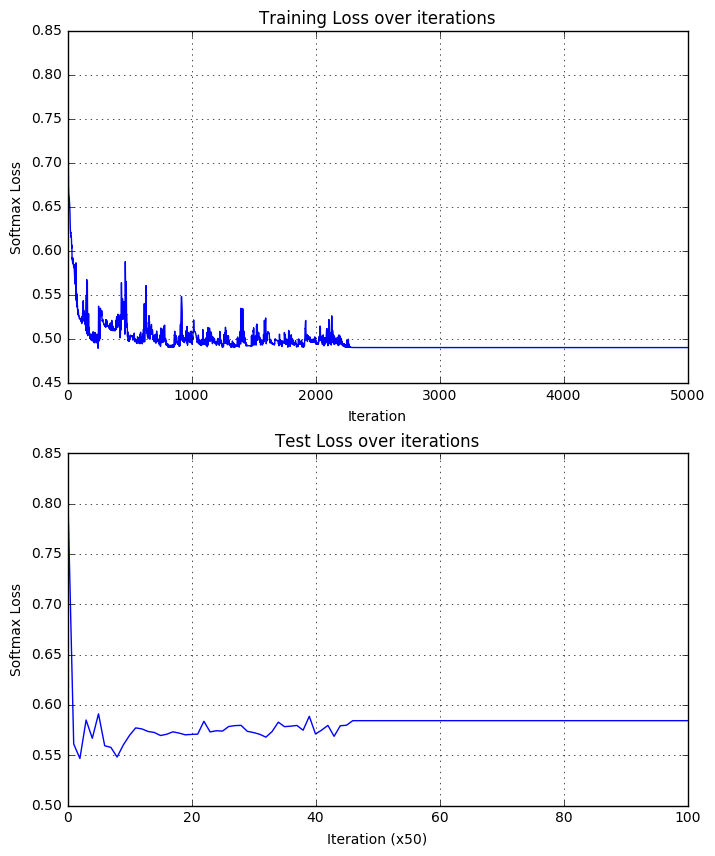

In [18]:
plt.figure(figsize=(8,10))
plt.subplot(211)
plt.title("Training Loss over iterations")
plt.xlabel("Iteration")
plt.ylabel("Softmax Loss")
plt.grid()
plt.plot(r_loss)
plt.subplot(212)
plt.title("Test Loss over iterations")
plt.xlabel("Iteration (x50)")
plt.ylabel("Softmax Loss")
plt.grid()
plt.plot(r_t_loss)


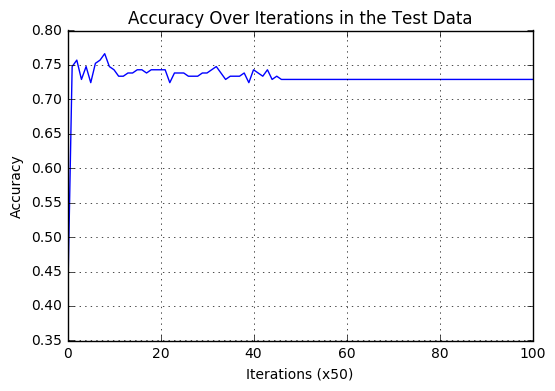

In [19]:
plt.title("Accuracy Over Iterations in the Test Data")
plt.xlabel("Iterations (x50)")
plt.ylabel("Accuracy")
plt.grid()
plt.plot(r_acc)

We can see our accuracy in the test data is aroun 74%, let's see if this is better than random guessing

In [20]:
# First we will decode the survival of the passengers, note tha [1, 0] OHE means the passenger survived, so we
# can use the first index of the encoding
seriesTest = pd.Series(test_Y)
seriesTest = seriesTest.apply(lambda x: x[0])
seriesTest.head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
dtype: float64

In [21]:
# Now we just have to sum all the values and divide by the total
seriesTest.sum() / len(seriesTest)

0.3925233644859813

It looks like out model is better than random guessing the values, since only 39% of the passengers survived and we are correct predicting the survival of about 74% of them.
Let's see if we can discover what were the most significant attributes for survival, we will use a decision tree from the sklearn toolkit.

In [22]:
import sklearn.tree as skltr

First, we will split the model again, using the same splits as before (70/30)

In [23]:
train = treated_data.sample(frac=0.7)
test = treated_data.drop(train.index)
train_Y = train['Survived'].as_matrix()
train.drop('Survived', axis=1, inplace=True)
test_Y = test['Survived'].as_matrix()
test.drop('Survived', axis=1, inplace=True)
train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
504,1.0,1.0,16.0,0.0,0.0,86.5000,0.0
282,3.0,0.0,16.0,0.0,0.0,9.5000,0.0
889,1.0,0.0,26.0,0.0,0.0,30.0000,1.0
804,3.0,0.0,27.0,0.0,0.0,6.9750,0.0
404,3.0,1.0,20.0,0.0,0.0,8.6625,0.0


In [24]:
# We will run the decision tree with the default parameters
decision_tree = skltr.DecisionTreeClassifier()
decision_tree.fit(train, train_Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [25]:
# Now we will predict the results and see the accuracy
prediction = decision_tree.predict(test)
print("Accuracy: ", sum((prediction == test_Y))/len(test_Y))

Accuracy:  0.752336448598


In [26]:
# We must now see if this is better than random guessing
print(sum(test_Y)/len(test_Y))

0.38785046729


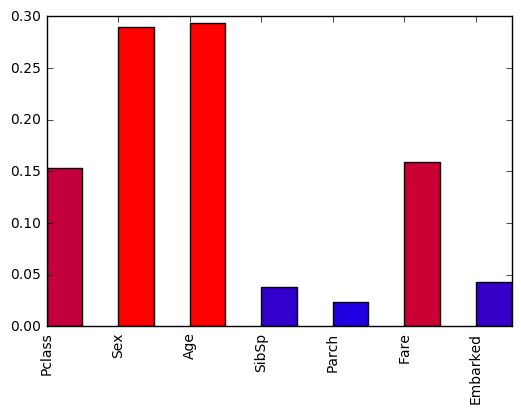

In [27]:
# Now we can see which features are more important
plt.xticks(range(0, 70, 10), train.columns, rotation=90)

for x, h in zip(range(0,70,10), decision_tree.feature_importances_):
    plt.bar(x, h, 5, color=(min(h*5, 1), 0, 1-min(h*5,1)))